# Classifying Biceps Curl Variations using Wearable Sensor Data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_csv(
    "Example_WearableComputing_weight_lifting_exercises_biceps_curl_variations.csv",
    skiprows=1,          # Skip the first metadata row
    na_values=["NaN", "NA", "", "#DIV/0!"]
)

print(df.head())
print(df.info())

  user_name  raw_timestamp_part_1  raw_timestamp_part_2    cvtd_timestamp  \
0    eurico            1322489729                 34670  28/11/2011 14:15   
1    eurico            1322489729                 62641  28/11/2011 14:15   
2    eurico            1322489729                 70653  28/11/2011 14:15   
3    eurico            1322489729                 82654  28/11/2011 14:15   
4    eurico            1322489729                 90637  28/11/2011 14:15   

  new_window  num_window  roll_belt  pitch_belt  yaw_belt  total_accel_belt  \
0         no           1       3.70        41.6     -82.8                 3   
1         no           1       3.66        42.8     -82.5                 2   
2         no           1       3.58        43.7     -82.3                 1   
3         no           1       3.56        44.4     -82.1                 1   
4         no           1       3.57        45.1     -81.9                 1   

   ...  gyros_forearm_x  gyros_forearm_y  gyros_forearm_z  acc

# Inspecting Missing Values

In [30]:
missing_percentage = df.isnull().mean() * 100
print(missing_percentage.sort_values(ascending=False).head(10))

kurtosis_yaw_belt         100.000000
skewness_yaw_belt         100.000000
skewness_yaw_dumbbell     100.000000
kurtosis_yaw_forearm      100.000000
skewness_yaw_forearm      100.000000
kurtosis_yaw_dumbbell     100.000000
amplitude_yaw_forearm      98.011928
kurtosis_yaw_arm           98.011928
skewness_yaw_arm           98.011928
kurtosis_picth_forearm     98.011928
dtype: float64


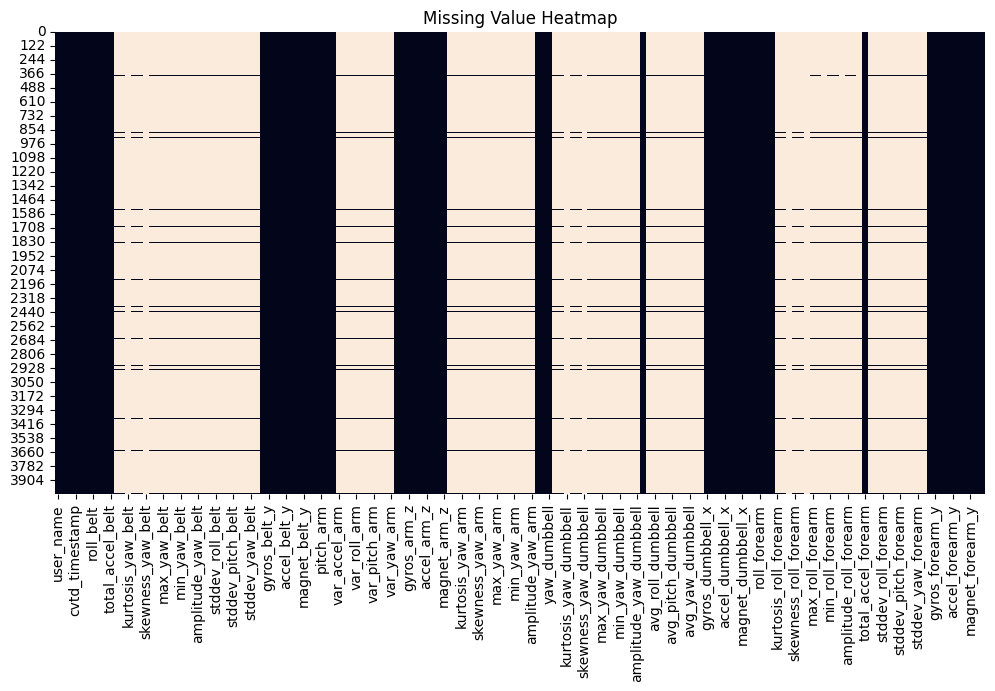

In [31]:
# Visualize missing data
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

# Handle Missing Values

In [32]:
# Drop columns with >95% missing
sparse_cols = missing_percentage[missing_percentage > 95].index
df.drop(columns=sparse_cols, inplace=True)

# Fill remaining numeric NaNs with median
df.fillna(df.median(numeric_only=True), inplace=True)

print("Remaining missing values:", df.isnull().sum().sum())

Remaining missing values: 0


In [33]:
# Check column data types
print(df.dtypes.head(15))  # Show first 15 columns and their types

# Check number of numeric columns
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
print("Number of numeric columns:", len(numeric_cols))

user_name                object
raw_timestamp_part_1      int64
raw_timestamp_part_2      int64
cvtd_timestamp           object
new_window               object
num_window                int64
roll_belt               float64
pitch_belt              float64
yaw_belt                float64
total_accel_belt          int64
gyros_belt_x            float64
gyros_belt_y            float64
gyros_belt_z            float64
accel_belt_x              int64
accel_belt_y              int64
dtype: object
Number of numeric columns: 55


In [34]:
# Fill remaining missing numeric values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Confirm no missing values remain
print("Remaining missing values:", df.isnull().sum().sum())

Remaining missing values: 0


# Outlier Detetction

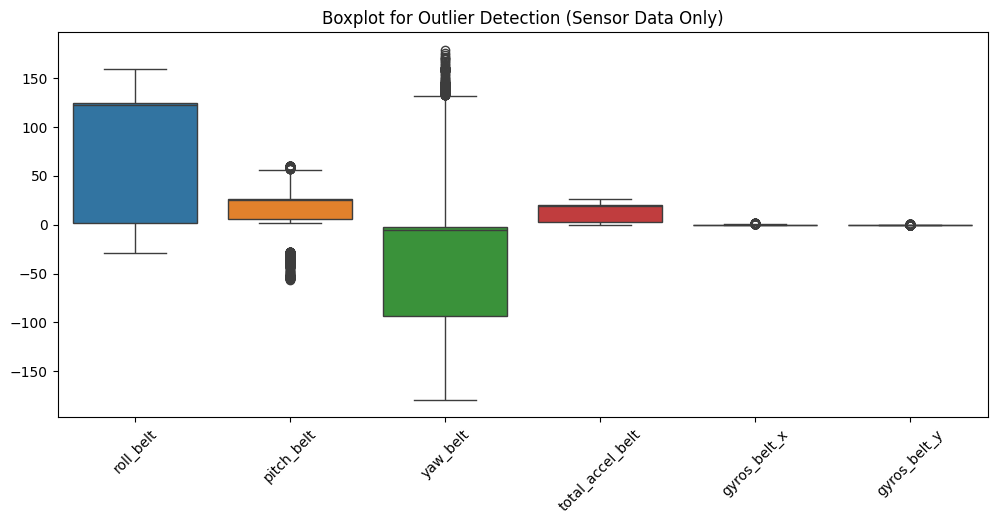

In [37]:
# Define sensor-only numeric columns
sensor_cols = df.drop(columns=[
    'user_name', 
    'raw_timestamp_part_1', 
    'raw_timestamp_part_2', 
    'cvtd_timestamp', 
    'num_window'
]).select_dtypes(include=['int64','float64']).columns

# Plot first 6 sensor columns
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.boxplot(data=df[sensor_cols[:6]])
plt.xticks(rotation=45)
plt.title("Boxplot for Outlier Detection (Sensor Data Only)")
plt.show()


# Feature Distributions

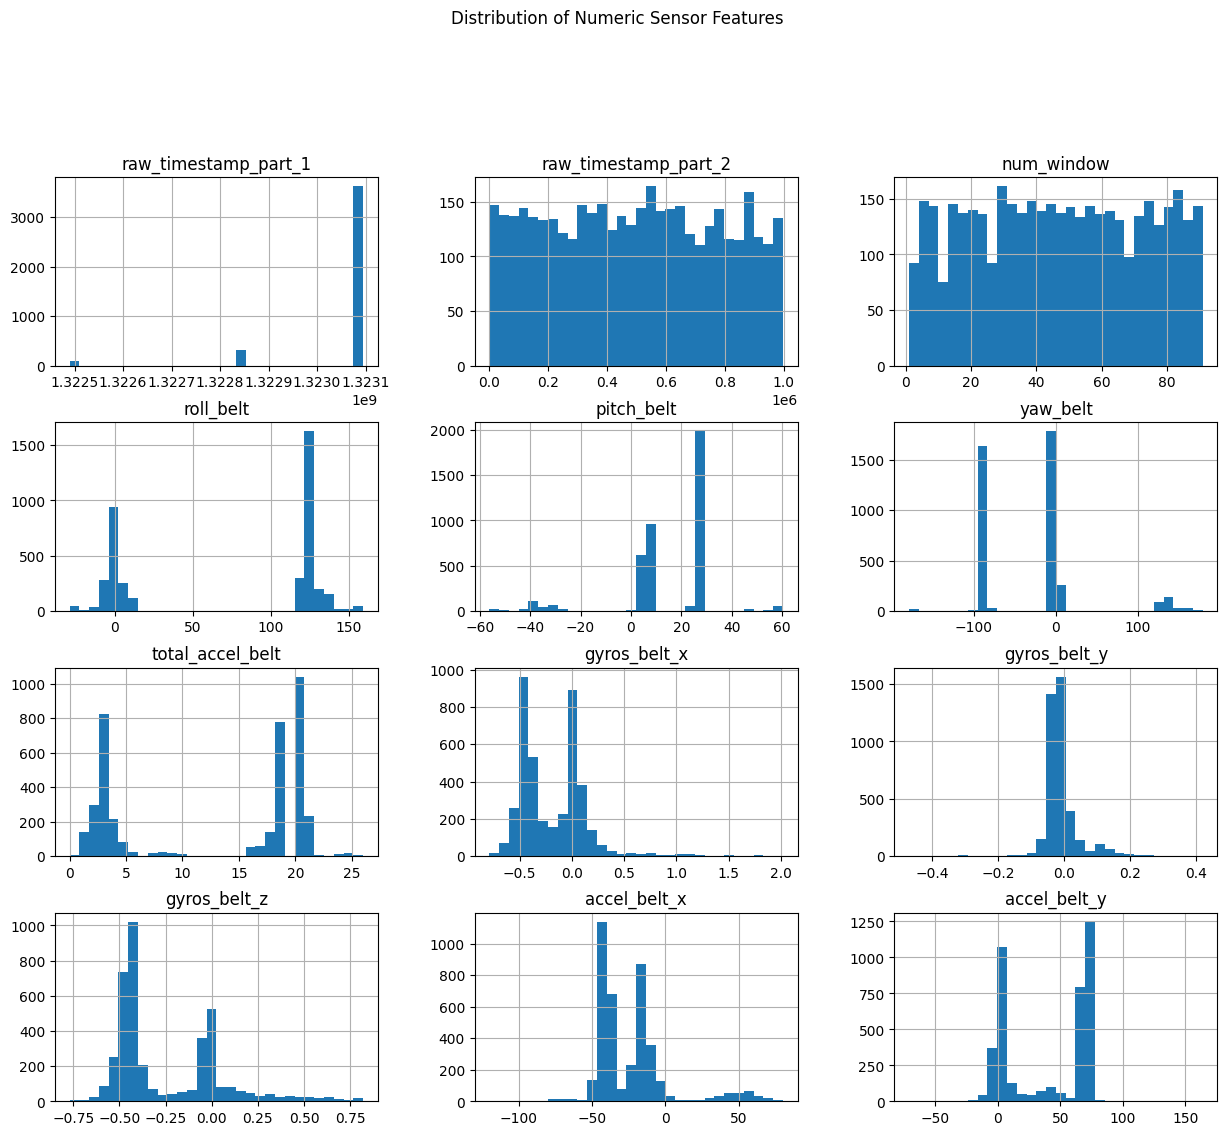

In [38]:
df[numeric_cols[:12]].hist(figsize=(15,12), bins=30)
plt.suptitle("Distribution of Numeric Sensor Features", y=1.02)
plt.show()

# Correlation Analysis

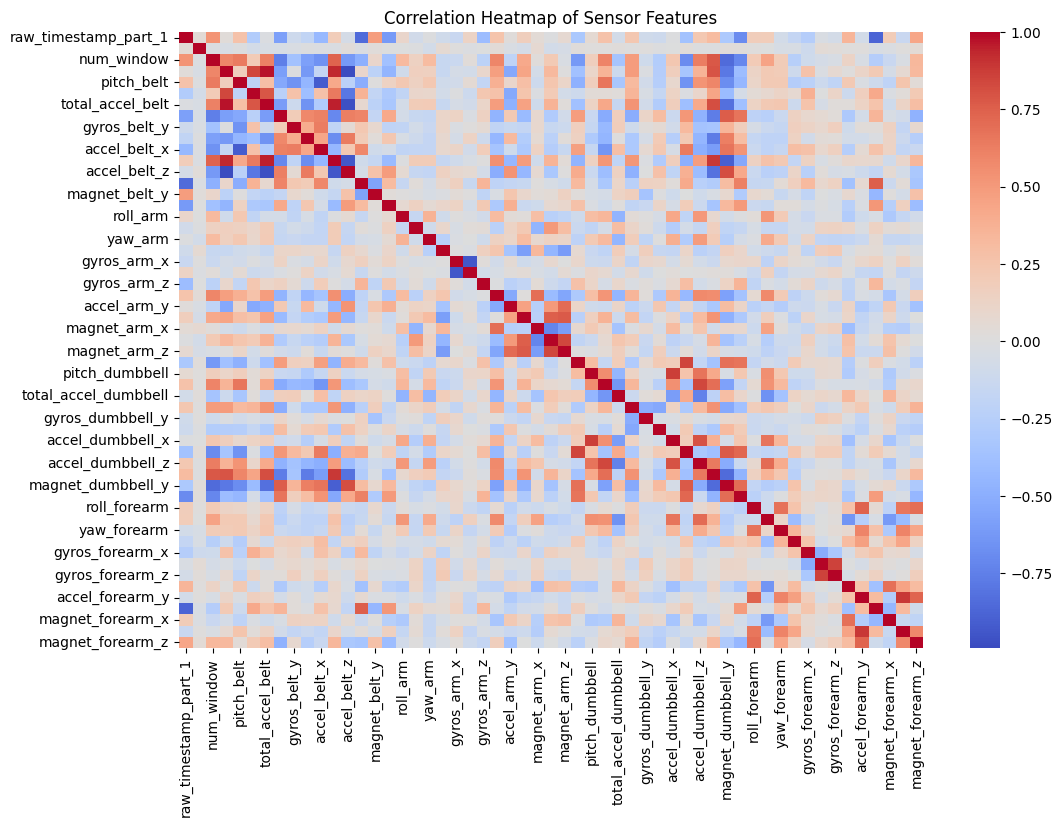

In [39]:
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm')
plt.title("Correlation Heatmap of Sensor Features")
plt.show()

In [40]:
# Confirm data cleanliness
print("Final shape:", df.shape)
print("Remaining missing values:", df.isnull().sum().sum())
print("Numeric columns:", len(numeric_cols))

# Optional: quick check of target distribution if 'classe' is target
if 'classe' in df.columns:
    print(df['classe'].value_counts())


Final shape: (4024, 59)
Remaining missing values: 0
Numeric columns: 55
classe
E    1370
A    1365
B     901
D     276
C     112
Name: count, dtype: int64


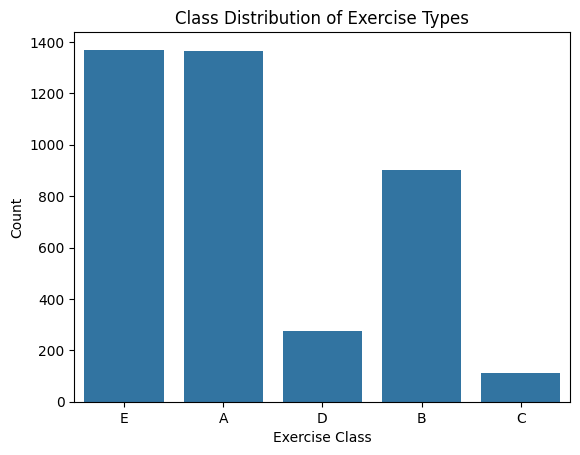

In [41]:
sns.countplot(x=df['classe'])
plt.title("Class Distribution of Exercise Types")
plt.xlabel("Exercise Class")
plt.ylabel("Count")
plt.show()


# Variance Analysis

In [44]:
low_variance = df[numeric_cols].std().sort_values().head(10)
print("Lowest variance features:\n", low_variance)


Lowest variance features:
 gyros_belt_y        0.057817
gyros_belt_z        0.289511
gyros_belt_x        0.318171
gyros_dumbbell_z    0.362490
gyros_dumbbell_x    0.404754
gyros_arm_z         0.488571
gyros_forearm_x     0.540884
gyros_dumbbell_y    0.700889
gyros_forearm_z     0.735418
gyros_arm_y         1.047446
dtype: float64


#  Correlation With Target (Feature Importance Hint)

In [45]:
# Encode target temporarily if needed
from sklearn.preprocessing import LabelEncoder

if df['classe'].dtype == 'object':
    df['classe_encoded'] = LabelEncoder().fit_transform(df['classe'])

cor_target = df[numeric_cols].corrwith(df['classe_encoded'])
cor_target.sort_values(ascending=False).head(10)

magnet_dumbbell_y    0.748473
gyros_belt_x         0.659434
magnet_dumbbell_z    0.638746
accel_belt_x         0.626323
accel_belt_z         0.559539
gyros_belt_z         0.527981
accel_dumbbell_y     0.487098
roll_dumbbell        0.415092
magnet_belt_x        0.396887
gyros_belt_y         0.311950
dtype: float64

# Sensor Axis Combinations

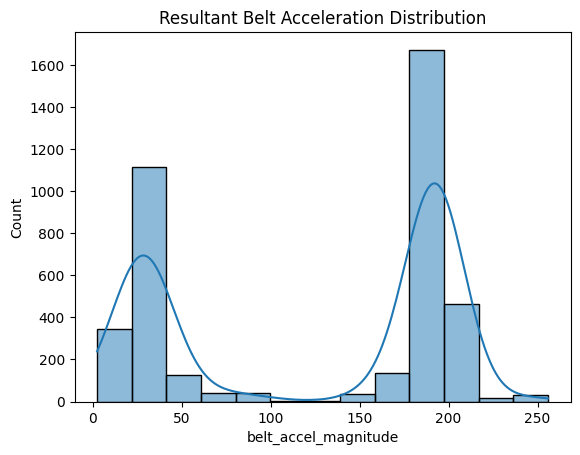

In [46]:
import numpy as np

df['belt_accel_magnitude'] = np.sqrt(
    df['accel_belt_x']**2 + df['accel_belt_y']**2 + df['accel_belt_z']**2
)

sns.histplot(df['belt_accel_magnitude'], kde=True)
plt.title("Resultant Belt Acceleration Distribution")
plt.show()
